In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [2]:
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

# === Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# === Carrega les dades
df = pd.read_csv("parelles2.csv").dropna()
examples = [InputExample(texts=[row['text_a'], row['text_b']], label=float(row['label'])) for _, row in df.iterrows()]
train_examples, test_examples = train_test_split(examples, test_size=0.2, random_state=42)

c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0605 10:32:55.530000 3480 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Device: cuda


In [3]:
# Analitza longituds
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("nomic-ai/modernbert-embed-base")
df["len_a"] = df["text_a"].apply(lambda x: len(tokenizer.tokenize(str(x))))
df["len_b"] = df["text_b"].apply(lambda x: len(tokenizer.tokenize(str(x))))
df["max_len"] = df[["len_a", "len_b"]].max(axis=1)
print("Percentil 95 llargada màxima:", df["max_len"].quantile(0.95))


Percentil 95 llargada màxima: 541.0


In [4]:
# === Model i loss
model = SentenceTransformer("nomic-ai/modernbert-embed-base")
#model.max_seq_length = 512  # no més
model.to(device)
train_loss = losses.ContrastiveLoss(model=model, distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE)

# === Dataloader amb collate
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2, collate_fn=model.smart_batching_collate)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# === Entrenament manual
model.train()
for epoch in range(3):
    total_loss = 0
    for features, labels in tqdm(train_dataloader, desc="Training"):
        # Moure cada diccionari de la llista a GPU
        features = [{k: v.to(device) for k, v in feature.items()} for feature in features]
        labels = labels.to(device)

        optimizer.zero_grad()
        loss = train_loss(features, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        del features, labels, loss
        torch.cuda.empty_cache()

    print(f"Epoch completed. Loss: {total_loss:.4f}")

# === Guarda el model
model.save("output/modernbert-contrastive-manual")


c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(
Training: 100%|██████████| 13123/13123 [5:13:43<00:00,  1.43s/it]  


Epoch completed. Loss: 42.1470


Training: 100%|██████████| 13123/13123 [4:14:57<00:00,  1.17s/it]  


Epoch completed. Loss: 10.0100


Training: 100%|██████████| 13123/13123 [4:05:46<00:00,  1.12s/it]  


Epoch completed. Loss: 5.5650


In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score
from torch.nn.functional import cosine_similarity
import numpy as np

model.eval()

y_true = []
y_scores = []

with torch.no_grad():
    for example in tqdm(test_examples, desc="Testing"):
        # Obtenim embeddings
        emb1 = model.encode(example.texts[0], convert_to_tensor=True, device=device)
        emb2 = model.encode(example.texts[1], convert_to_tensor=True, device=device)

        # Similitud de cosinus → com a score
        sim = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()

        y_true.append(example.label)
        y_scores.append(sim)

# === Mètriques
auc = roc_auc_score(y_true, y_scores)
acc = accuracy_score(y_true, [1 if s > 0.5 else 0 for s in y_scores])

print(f"📈 AUC: {auc:.4f}")
print(f"✅ Accuracy (umbral 0.5): {acc:.4f}")


Testing: 100%|██████████| 6562/6562 [09:34<00:00, 11.41it/s]

📈 AUC: 0.9999
✅ Accuracy (umbral 0.5): 0.9895


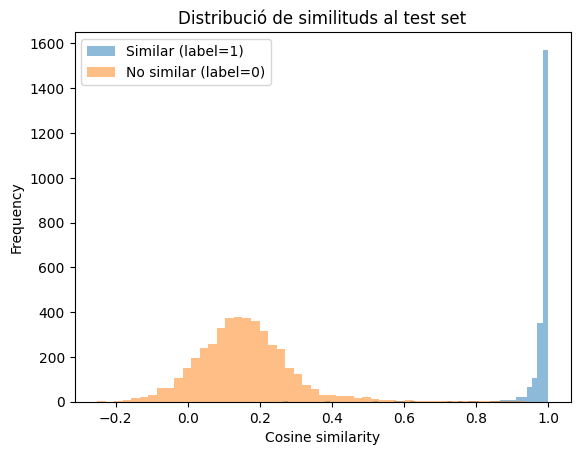

In [6]:
import matplotlib.pyplot as plt

plt.hist([s for s, y in zip(y_scores, y_true) if y == 1], bins=50, alpha=0.5, label="Similar (label=1)")
plt.hist([s for s, y in zip(y_scores, y_true) if y == 0], bins=50, alpha=0.5, label="No similar (label=0)")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribució de similituds al test set")
plt.show()


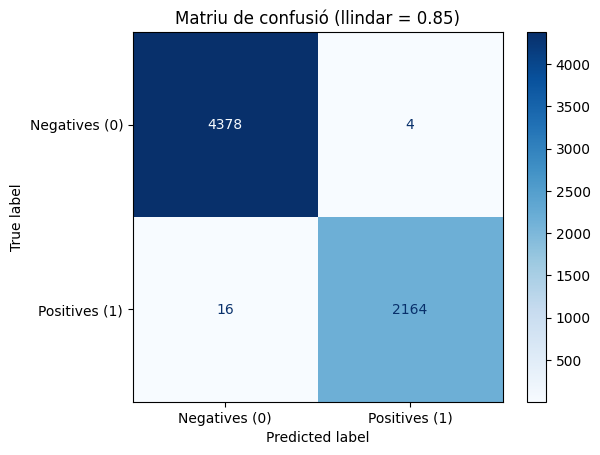

🔢 Valors:
TN (negatives correctes): 4378
FP (falsos positius):     4
FN (falsos negatius):     16
TP (positives correctes): 2164


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ───────────────────────────────────────────────────
# Tria un llindar per fer classificació binària
llindar = 0.85  # pots ajustar-ho (0.5, 0.75, etc.)

# Generem prediccions: si similitud > llindar → positiva
prediccions = [1 if s >= llindar else 0 for s in y_scores]

# ───────────────────────────────────────────────────
# Matriu de confusió
cm = confusion_matrix(y_true, prediccions)
labels = ["Negatives (0)", "Positives (1)"]

# Mostrem matriu
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title(f"Matriu de confusió (llindar = {llindar})")
plt.show()

# També mostrem les xifres
tn, fp, fn, tp = cm.ravel()
print("🔢 Valors:")
print(f"TN (negatives correctes): {tn}")
print(f"FP (falsos positius):     {fp}")
print(f"FN (falsos negatius):     {fn}")
print(f"TP (positives correctes): {tp}")
